In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 306M/309M [00:17<00:00, 19.9MB/s]
100% 309M/309M [00:17<00:00, 18.5MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.src.layers import MultiHeadAttention
from tensorflow.keras.layers import Layer, Dropout,MaxPooling2D,GlobalAveragePooling2D,Activation,Add,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer,Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Input,RandomFlip, RandomRotation, Resizing, Rescaling,RandomContrast
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
import sklearn
import tensorflow_probability as tfp
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2, L1
from tensorflow.train import BytesList,FloatList,Int64List
from tensorflow.train import Example, Feature, Features
import seaborn as sns
import  cv2
from tensorflow.keras.callbacks import Callback, CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau

In [ ]:
train_datasat_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dataset_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CONFIG = {
    "IM_SIZE" : 256,
    "BATCH_SIZE" : 32,
}


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_datasat_path,
    labels= "inferred",
    label_mode = "int",
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle = True,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset_path,
    labels= "inferred",
    label_mode = "int",
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle = True,
)

Found 2278 files belonging to 3 classes.


In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
CLASS_NAMES = ["angry","happy","sad"]
print(CLASS_NAMES)

['angry', 'happy', 'sad']


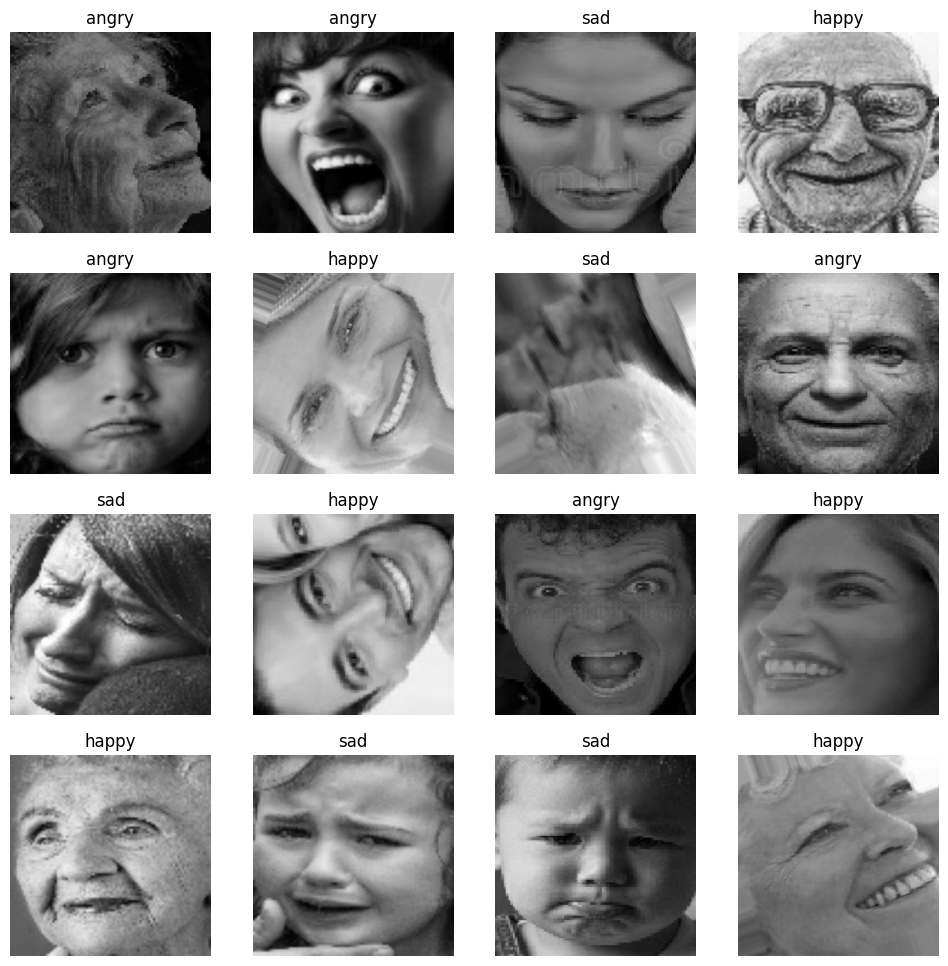

In [ ]:
plt.figure(figsize = (12,12))

for images,labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title(CLASS_NAMES[labels[i].numpy()])
    plt.imshow(images[i]/255.)
    plt.axis("off")

In [ ]:
print(f"Train Size: {len(train_ds)} Val Size: {len(val_ds)}")
print(train_ds)
print(val_ds)

Train Size: 213 Val Size: 72
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
model = tf.keras.models.Sequential([
    InputLayer(input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),
    Rescaling(1./255, name = "rescaling"),


    Conv2D(filters = 16, kernel_size = 3,strides = 1,activation = 'relu'),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 32, kernel_size = 3,strides = 1,activation = 'relu'),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 64, kernel_size = 3,strides = 1,activation = 'relu'),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(512,activation = "relu"),
    Dense(100,activation = "relu"),

    Dense(len(CLASS_NAMES),activation = "softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [ ]:
model.compile(optimizer = 'adam', loss = SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 20)

Epoch 1/20
213/213 [==============================] - 14s 65ms/step - loss: 0.0589 - accuracy: 0.9793 - val_loss: 1.3447 - val_accuracy: 0.7612
Epoch 2/20
213/213 [==============================] - 16s 75ms/step - loss: 0.0507 - accuracy: 0.9797 - val_loss: 1.4596 - val_accuracy: 0.7362
Epoch 3/20
213/213 [==============================] - 15s 67ms/step - loss: 0.0593 - accuracy: 0.9784 - val_loss: 1.4585 - val_accuracy: 0.7612
Epoch 4/20
213/213 [==============================] - 14s 62ms/step - loss: 0.0501 - accuracy: 0.9807 - val_loss: 1.4055 - val_accuracy: 0.7643
Epoch 5/20
213/213 [==============================] - 13s 60ms/step - loss: 0.0552 - accuracy: 0.9782 - val_loss: 1.3234 - val_accuracy: 0.7485
Epoch 6/20
213/213 [==============================] - 13s 59ms/step - loss: 0.0466 - accuracy: 0.9796 - val_loss: 1.6412 - val_accuracy: 0.7520
Epoch 7/20
213/213 [==============================] - 14s 64ms/step - loss: 0.0412 - accuracy: 0.9816 - val_loss: 1.4904 - val_accuracy:

In [ ]:
model.evaluate(val_ds)

72/72 [==============================] - 3s 39ms/step - loss: 2.0251 - accuracy: 0.7599


[2.0251305103302, 0.75987708568573]

1/1 [==============================] - 0s 21ms/step


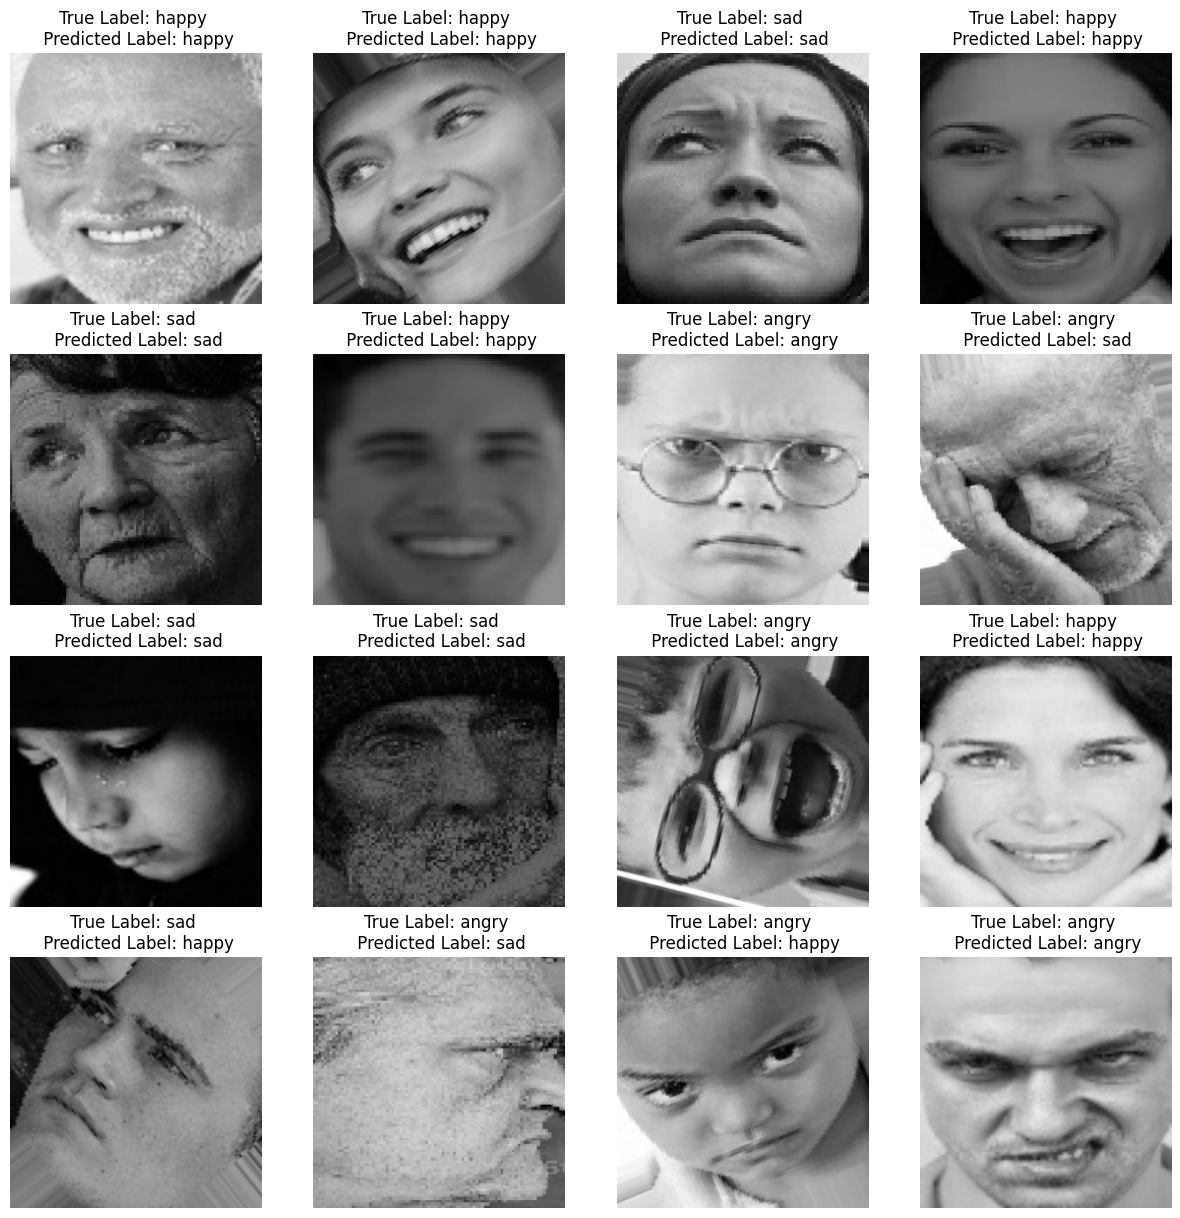

In [ ]:
plt.figure(figsize = (15,15))

for images,labels in val_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    true_label = CLASS_NAMES[labels[i].numpy()]
    predicted_img = tf.expand_dims(images[i],axis = 0)
    predictd_label = CLASS_NAMES[np.argmax(model.predict(predicted_img))]
    plt.title(f"True Label: {true_label} \n Predicted Label: {predictd_label}")
    plt.imshow(images[i]/255.)
    plt.axis("off")